## Data mining questions

1- Is fully-connected model a good one for sequential data? Why? How about for image data? Is it good? Why?
- no because they cant preserve information from from previous timesteps
- not better than the cnn but it can be used with it and we can combine them together (CNN-FCL) and has proven to be very effective for image classification. However, it should be noted that fully-connected models can be prone to overfitting



2- What is gradient vanishing and gradient explosion, and how GRU/LSTM tries to mitigate this problem?

- These problems arise when gradients become too small or too large during backpropagation, which can lead to slow or unstable learning.
- To mitigate these problems, LSTM and GRU networks use a gating mechanism that allows them to selectively remember or forget information from previous time steps.

---


3- What is multi-objective/multi-task learning? What is multi-modality learning? How do you use them in this assignment?
- multi-objective/multi-task learning training of a neural network to perform multiple related tasks simultaneously
- Multi-modality learning (MML) refers to the training of a neural network to learn from multiple modalities of data, such as images, speech, text, or other types of input
---

4- What is the difference among xgboost, lightgbm and catboost

- each of these frameworks has its own strengths and weaknesses
- Speed : LightGBM and CatBoost are typically faster than XGBoost
- Memory usage : LightGBM and CatBoost are designed to use less memory than XGBoost.
- Handling categorical features: CatBoost is specifically designed to handle categorical features more effectively than XGBoost or LightGBM
- Regularization : LightGBM and CatBoost both offer additional regularization techniques that are not available in XGBoost

# problem formulation
</br>

### problem definition

- our problem here is about building a model to classify the price, our inputs here are summary and image (7627) for a training dataset and the output is price(7627).
---

### Data mining function
- text preprocessing -> tokenization and vectorization each text ->training the model -> classification and prediction.

---

### Challenges

- We have a very big data set so maybe will take some time to preprocess it and train it.

- imbalanced labels distribution.
- The size of training dataset is smaller that test dataset
---

### Model impact

- Predicting the actual price class beginner, plus, premium

---

### The ideal solution

- by only using the text and not using images i got the highest score


## Experimental protocol

### Data preprocessing
---
- cleaning input data for both training set and test set using stemming 
- (tried translating but it got lower accuracy)
- tokenizing
- loading images and resizing it
---
### Building models

- trying different neural network architecture then try to tune hyperparameters of the best one

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permissionn


kaggle.json


In [38]:
#! kaggle competitions download copy-of-cisc-873-dm-w23-a4
#! unzip copy-of-cisc-873-dm-w23-a4.
#!pip install git+https://github.com/neuml/txtai
#!pip install sacremoses
!pip install pipeline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install mtranslate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for mtranslate: filename=mtranslate-1.8-py3-none-any.whl size=3697 sha256=de61e0c83866744448efb81478ae3c23a93c5c936aec6ce332ccbc69e3469288
  Stored in directory: /root/.cache/pip/wheels/a2/20/13/93c62f314d4a29db25b1b24b2c38f79eb1beb558c727b894a3
Successfully built mtranslate


In [47]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Conv1D,GlobalMaxPooling1D, Dense, MaxPool2D, LSTM, Dropout, Bidirectional, GRU, MultiHeadAttention
from tensorflow.keras.optimizers import Adam, Nadam
from keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from tensorflow.keras import regularizers
import nltk 
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from PIL import Image
from keras.callbacks import ReduceLROnPlateau
from tqdm.notebook import tqdm
from mtranslate import translate

In [7]:
# Reading training and testing Data from kaggle
df_train = pd.read_csv('a4/train_xy.csv')
df_test = pd.read_csv('a4/test_x.csv')

# Data Exploration

In [8]:
#taking a first look at our data
df_train.head()

,summary,image,type,price
0,"Spacious, sunny and cozy modern apartment in t...",img_train/0.jpg,Apartment,1
1,Located in one of the most vibrant and accessi...,img_train/1.jpg,Apartment,0
2,Logement coquet et douillet à 10 minutes du ce...,img_train/2.jpg,Apartment,1
3,"Beautiful and spacious (1076 sc ft, / 100 mc) ...",img_train/3.jpg,Apartment,1
4,Très grand appartement ''rustique'' et très ag...,img_train/4.jpg,Apartment,0


we can see in the summary column that there values with different languages like french, therefore we will have to translate them to english in the preprocessing phase

In [9]:
#describing the data
df_train.describe()

,price
count,7627.000000
mean,0.442769
std,0.611946
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7627 entries, 0 to 7626
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   summary  7326 non-null   object
 1   image    7627 non-null   object
 2   type     7627 non-null   object
 3   price    7627 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 238.5+ KB


In [12]:
df_train['price'].value_counts()

0    4737
1    2403
2     487
Name: price, dtype: int64

price column has only 3 unique values which mean we can label it as  a categorical column if we need to

<Axes: xlabel='count', ylabel='price'>

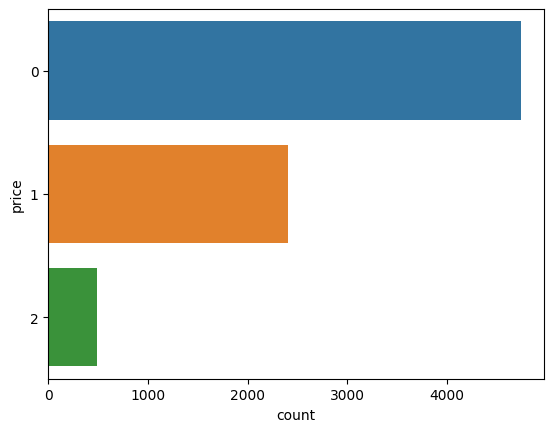

In [14]:
sns.countplot(y="price", data = df_train)

In [21]:
print("Training Data Shape: ", df_train.shape)
print("Testing Data Shape: ", df_test.shape)

Training Data Shape:  (7627, 4)
Testing Data Shape:  (7360, 3)


# Data Cleaning

In [20]:
#check for missing values for training and testing data
print("Training Data missing values: ",df_train.isnull().sum())
print("Testing Data missing values: ",df_test.isnull().sum())

Training Data missing values:  summary    301
image        0
type         0
price        0
dtype: int64
Testing Data missing values:  id         0
summary    0
image      0
dtype: int64


looks like we have a small number of missing values in the training data 

In [18]:
#dropping missing values
df_train.dropna(inplace=True)

id         0
summary    0
image      0
dtype: int64

In [22]:
#check for duplicates for training and testing data
print("Training Data duplicates: ",df_train.duplicated().sum())
print("Testing Data duplicates: ",df_test.duplicated().sum())

Training Data duplicates:  0
Testing Data duplicates:  0


#Preprocessing
###1- translation
for translation i used mtranslate which is faster than google translate and has unlimited access

In [5]:
#translate the summary column for both datasets
# for i in tqdm(range(len(df_train))):
#     df_train.at[i,'summary'] = translate(str(df_train.at[i,'summary']) ,'en')
    
# print("Done train_df..\n")
    

# for i in tqdm(range(len(df_test))):
#    df_test.at[i,'summary'] = translate(df_test.at[i,'summary'] ,'en')
# print("Done test_df..\n")


# df_train.to_csv('df_train_translated.csv', index=False)
# df_test.to_csv('df_test_translated.csv', index=False)

df_train = pd.read_csv("df_train_translated.csv")
df_test = pd.read_csv("df_test_translated.csv")

i saved the translated files so we don't have to translate again

###2- text cleaning
i used the same preprocessing helper function from the past competition for the summary text column

In [6]:
nltk.download('punkt') # punkt is a tokenizer uses an unsupervised algorithm to divide a text into a list of sentences.
nltk.download('stopwords') # download english stopwords

stemmer = SnowballStemmer("english")   # It is the method used to return the word to its original form
stop_words = set(stopwords.words("english")) # It is the method of producing a stop words

def clean_text(text):

    # IGNORECASE : is a flag allows for case-insensitive matching of the Regular Expression with the given string
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE) # Remove any more than one space
    RE_TAGS = re.compile(r"<[^>]+>") # Remove web tags
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE) # Remove any leter does not english charachter
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE) # Remove any single character

    text = re.sub(RE_TAGS, " ", text)# Replace any tag with a single space.
    text = re.sub(RE_ASCII, " ", text) # Replace any non english character with a single space.
    text = re.sub(RE_SINGLECHAR, " ", text) # Replace any single character with a single space.
    text = re.sub(RE_WSPACE, " ", text)  # Replace any more than one space with a single space.

    word_tokens = word_tokenize(text) # split the sentence into words
    words_tokens_lower = [word.lower() for word in word_tokens] # Convert all letters to small letters

    # words_filtered (Words can be filtered based on how many times they appear)
    # stemmer used to return the word to its original form.
    words_filtered = [
        stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
    ]

    # Join all words in text_clean and separate them by space.
    text_clean = " ".join(words_filtered)
    return text_clean

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Call function to clean text

In [7]:
df_train["summary"] = df_train["summary"].map(lambda x: clean_text(x) if isinstance(x, str) else x).copy() ## clean and lemmatiz training set
df_test["summary"] = df_test["summary"].map(lambda x: clean_text(x) if isinstance(x, str) else x).copy() ## word cleaning and lemmatizing test set

### 3- Image Loading

In [8]:
#Helper function to load images
def load_image(file):
    try:
        image = Image.open(
            file
        ).convert('LA').resize((64, 64)) # read each image as a greyscale image size (64x64x2)
        arr = np.array(image)
    except:
        arr = np.zeros((64, 64,2))       # if an image can't be loaded, return an array of zeros (same size: 64x64x2)
    return arr

In [9]:
# loading images for training:
x_train_image = np.array([load_image(i) for i in tqdm(df_train['image'])])

# loading images for testing:
x_test_image = np.array([load_image(i) for i in tqdm(df_test['image'])])

  0%|          | 0/7326 [00:00<?, ?it/s]

  0%|          | 0/7360 [00:00<?, ?it/s]

In [10]:
df_train.summary = df_train.summary.astype('str')
df_test.summary = df_test.summary.astype('str')

# labels:
y_price = df_train.price # price category/label, either 0, 1, or 2 corresponding to beginner, plus, or premium respectively
y_type = df_train.type.astype('category').cat.codes # rental type label, categorically encode 24 available property types (i.e. hotel, apartment, villa, boat, etc.)
#features
x_train_text=df_train.summary
len_price = len(y_price.unique()) # number of unique labels for price
len_type = len(y_type.unique()) # number of unique labels for rental type
print('unique values for price category', len_price, y_price.unique()) # print them so we can see the unique values for our labels
print('unique values for type category', len_type, y_type.unique())

unique values for price category 3 [1 0 2]
unique values for type category 24 [ 1 17 22 10 18 20  8  4 23  2  5 13 15 16 14 11 19  0 21  3  6 12  7  9]


### 4- tokenizing

In [11]:
vocab_size = 40000
max_len = 100


# build vocabulary from training set
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(x_train_text)


def _preprocess(list_of_text):
    return pad_sequences(
        tokenizer.texts_to_sequences(list_of_text),
        maxlen=max_len,
        padding='post',
    )
    

# padding is done inside: 
x_train_text_id = _preprocess(x_train_text)
x_test_text = _preprocess(df_test['summary'].astype('str'))

print(x_train_text_id.shape)
print(x_test_text.shape)

(7326, 100)
(7360, 100)


In [12]:
#first output shape
print("first output",len(df_train.type.unique()))
#second output shape
print("second output", len(df_train.price.unique()))

first output 24
second output 3


In [13]:
print('total words in the dictionary:', tokenizer.num_words)

total words in the dictionary: 40000


In [14]:
#creates training and validation splits for our image and text feature spaces
# along with our two label sets, price and rental type
x_tr_image, x_vl_image, x_tr_text, x_vl_text, y_tr_price, y_vl_price, y_tr_type, y_vl_type = train_test_split(x_train_image, x_train_text_id, y_price, y_type, test_size=0.2) # our validation splits are a hold-out set containing 20% of the training set

# Model building

In [15]:
# method used to plot history after training to explore model behaviour
def visualize(history):

  # generate a figure containing 3 plots displayed horizontally
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
  fig.suptitle('Model Results')
  
  # first we display the training price accuracy vs. the validation price accuracy
  ax1.plot(history.history['price_sparse_categorical_accuracy'])
  ax1.plot(history.history['val_price_sparse_categorical_accuracy'])
  ax1.set_title('price accuracy')
  ax1.set_ylabel('accuracy')
  ax1.set_xlabel('epoch')
  ax1.legend(['train_price', 'validation_price'], loc='upper left')

  # same with the other specified accuracy metric, type accuracy
  ax2.plot(history.history['type_sparse_categorical_accuracy'])
  ax2.plot(history.history['val_type_sparse_categorical_accuracy'])
  ax2.set_title('type accuracy')
  ax2.set_ylabel('accuracy')
  ax2.set_xlabel('epoch')
  ax2.legend(['train_type', 'validation_type'], loc='upper left')

  # on the last axis, we plot the training loss against the validation loss (w.r.t. price and type combined)
  ax3.plot(history.history['loss'])
  ax3.plot(history.history['val_loss'])
  ax3.set_title('model loss')
  ax3.set_ylabel('loss')
  ax3.set_xlabel('epoch')
  ax3.legend(['train', 'validation'], loc='upper left')

  plt.show() # display the figure


def compile(model, lr=0.001):
  # compile model
  model.compile(
      optimizer=Adam(learning_rate=lr), # using Adam for optimization
      # measuring sparse categorical cross-entropy loss for both price and type labels
      # sparse categorical cross-entropy is used since our labels are integers
      loss={
          'price': 'sparse_categorical_crossentropy',
          'type': 'sparse_categorical_crossentropy',
      },
      # equally weight the loss w.r.t. both labels
      loss_weights={
          'price': 0.5,
          'type': 0.5,       
      },
      # evaluation metric for this task is accuracy, so we measure sparse categorical accuracy for both targets
      # again, our labels are categorical integers, so we use sparse categorical accuracy
      metrics={
          'price': ['SparseCategoricalAccuracy'],
          'type': ['SparseCategoricalAccuracy'],
      },
  )

def train(model, cbs, epochs=20, batch=16, val=0.2):
  # fit our model on our training data
  history = model.fit(
      # our inputs: tokenized text sequences and resized image samples
      x={
          'summary': x_tr_text,
          'image': x_tr_image
      },
      # our outputs: price and rental type categories
      y={
          'price': y_tr_price,
          'type': y_tr_type,
      },
      epochs=epochs, # variable, number of iterations over all training data
      batch_size=batch, # variable batch size, samples processed before updating gradients
      # our validation splits for our two input sets and our two target attributes
      validation_data=(
          {
              'summary': x_vl_text,
              'image': x_vl_image
          }, 
          {
              'price': y_vl_price,
              'type': y_vl_type,
          }),
      validation_split=val, # validate on a hold-out set of 20%, even though splits were already created above???? This is redundant.
      # use early stopping, monitor the validation price loss and if it does not improve for 5 consecutive epochs, training will stop
      callbacks=cbs,
      verbose=1 # one line per epoch displaying performance metrics
  )
  return history

# Trial 1
## Text part
- Embedding layer
- Average layer
- Dropout = 50% to reduce overfitting.
## Image part
- Convolutional layer with 32 filters, and a 16*16 mask
- Max pooling with a 16*16 mask
- Flatten layer

In [16]:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text)# embedding requires to encoded input data to integer encoded, so that each word is represented by a unique integer
averaged = tf.reduce_mean(embedded, axis=1)  # reduce_mean that compute the mean value of embeddded
averaged= Dropout(0.5)(averaged)# 50% dropout

# image part 
# Conv2D is a two-dimensional convolution layer that generates a tensor of outputs by winding a convolution kernel with the layers input
# MaxPool2D used to reduces the dimensionality of images that is  by reducing the number of pixels in the output from the previous convolutional layer.
cov = Conv2D(32, (16, 16))(in_image) # convolutional layer with 32 filters, and a 16*16 mask, no padding
pl = MaxPool2D((16, 16))(cov) # max pooling with a 16*16 mask
flattened = Flatten()(pl) # flatten the shape to (288,)

# fusion - combinig both the text and the image
fused = tf.concat([averaged, flattened], axis=-1)

# multi-task learning (each is a multi-class classification)
# one dense layer for each task(type and price)
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)


# define model input/output using keys.
model = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)


# compile model with optimizer, loss values for each task, loss 
# weights for each task.
model.compile(
    optimizer=Adam(),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'type': 0.5,
        'price': 0.5,       
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     4000000     ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 49, 49, 32)   16416       ['input_2[0][0]']                
                                                                                              

In [17]:
# fit our model on our training data
history = model.fit(
    # our inputs: tokenized text sequences and resized image samples
    x={
        'summary': x_tr_text,
        'image': x_tr_image
    },
    # our outputs: price and rental type categories
    y={
        'price': y_tr_price,
        'type': y_tr_type,
    },
    epochs=20, # train for 20 epochs (iterations over all training data)
    batch_size=16, # batch size of 16 (samples processed before updating gradients)
    # our validation splits for our two input sets and our two target attributes
    validation_data=(
        {
            'summary': x_vl_text,
            'image': x_vl_image
         }, 
        {
            'price': y_vl_price,
            'type': y_vl_type,
        }),
    validation_split=0.2, # validate on a hold-out set of 20%, even though splits were already created above???? Pretty sure this is redundant.
    # use early stopping, monitor the validation price loss and if it does not improve for 5 consecutive epochs, training will stop
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, )
    ],
    verbose=1 # one line per epoch displaying performance metrics
)

Epoch 1/20
367/367 [==============================] - 41s 81ms/step - loss: 1.0427 - price_loss: 0.8523 - type_loss: 1.2332 - price_sparse_categorical_accuracy: 0.6140 - type_sparse_categorical_accuracy: 0.7503 - val_loss: 0.9112 - val_price_loss: 0.8168 - val_type_loss: 1.0056 - val_price_sparse_categorical_accuracy: 0.6419 - val_type_sparse_categorical_accuracy: 0.7572
Epoch 2/20
367/367 [==============================] - 8s 23ms/step - loss: 0.9035 - price_loss: 0.8206 - type_loss: 0.9863 - price_sparse_categorical_accuracy: 0.6166 - type_sparse_categorical_accuracy: 0.7589 - val_loss: 0.9046 - val_price_loss: 0.8185 - val_type_loss: 0.9906 - val_price_sparse_categorical_accuracy: 0.6596 - val_type_sparse_categorical_accuracy: 0.7572
Epoch 3/20
367/367 [==============================] - 5s 14ms/step - loss: 0.8759 - price_loss: 0.7854 - type_loss: 0.9664 - price_sparse_categorical_accuracy: 0.6386 - type_sparse_categorical_accuracy: 0.7589 - val_loss: 0.8666 - val_price_loss: 0.7654

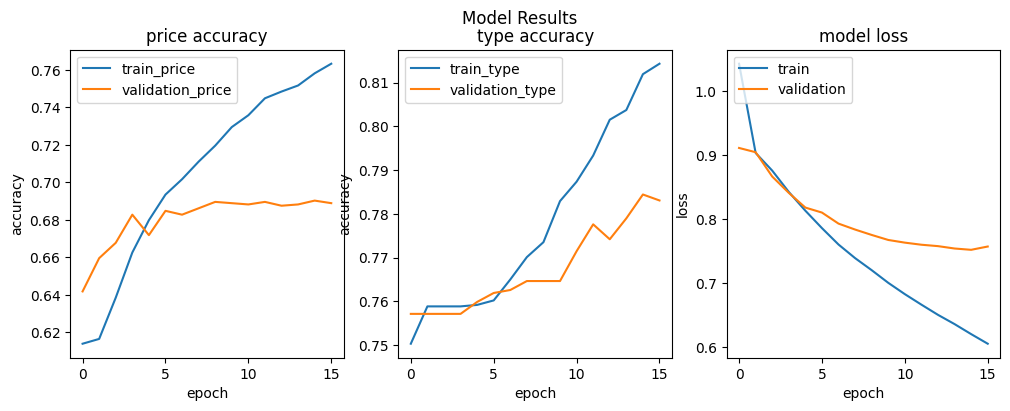

In [18]:
# visualize the accuracy and loss of the model using helper function
visualize(history)

In [19]:
#start predicting the values of type and price using summary and image as inputs
first_prediction = model.predict(
    {
        'summary': x_test_text,
        'image': x_test_image
    }
)


# probabilities
first_prediction = first_prediction['price']
print(first_prediction)

# categories
first_prediction = np.argmax(first_prediction, axis=1)
print(first_prediction)

230/230 [==============================] - 1s 3ms/step
[[0.56458646 0.36991054 0.06550295]
 [0.9442115  0.05065702 0.00513152]
 [0.76687866 0.18687929 0.04624208]
 ...
 [0.71599346 0.25830284 0.02570374]
 [0.9567259  0.03624928 0.00702484]
 [0.77077734 0.20296623 0.02625648]]
[0 0 0 ... 0 0 0]


In [20]:
pd.DataFrame(
    {'id': df_test['id'],
     'price': first_prediction}
).to_csv('trial1.csv', index=False)

Observation: 67% on kaggle

#Trial 2 
###LSTM and conv2d between embedded to increase accuracy on Text

In [21]:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2)) # input shape for batches of images (size 64x64x2)

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # get our word embeddings

# only part I'm changing is adding an LSTM layer on top of the embedding layer
# averaged = tf.reduce_mean(embedded, axis=1) # compute the mean of the embeddings to reduce the rank of the embedding
lstm = LSTM(50)(embedded)

# image part
cov = Conv2D(32, (16, 16))(in_image) # convolutional layer with 32 filters, and a 16x16 mask, no padding
pl = MaxPool2D((16, 16))(cov) # max pooling with a 16x16 mask, reducing the size to 3x3x32
flattened = Flatten()(pl) # flatten the shape to (288,)


# fusion:
fused = tf.concat([lstm, flattened], axis=-1) # concatenate text features with images

# multi-objectives (each is a multi-class classification)
p_price = Dense(len_price, activation='softmax', name='price')(fused) # predict price label 0, 1, or 2
p_type = Dense(len_type, activation='softmax', name='type')(fused) # predict rental category label [0-23]

# model definition
lstm_model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price, # label 1: price category (0, 1, or 2)
        'type': p_type, # label 2: type category [0-23]
    },
)

compile(lstm_model) # compiles the model with the helper to improve readability
lstm_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 49, 49, 32)   16416       ['input_4[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 100)     4000000     ['input_3[0][0]']                
                                                                                            

In [22]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=10,)]

In [23]:
#train model using helper function
history = train(lstm_model, callbacks)

Epoch 1/20
367/367 [==============================] - 29s 68ms/step - loss: 0.9901 - price_loss: 0.8580 - type_loss: 1.1222 - price_sparse_categorical_accuracy: 0.6089 - type_sparse_categorical_accuracy: 0.7572 - val_loss: 0.9190 - val_price_loss: 0.8239 - val_type_loss: 1.0142 - val_price_sparse_categorical_accuracy: 0.6419 - val_type_sparse_categorical_accuracy: 0.7572
Epoch 2/20
367/367 [==============================] - 7s 20ms/step - loss: 0.9224 - price_loss: 0.8416 - type_loss: 1.0032 - price_sparse_categorical_accuracy: 0.6152 - type_sparse_categorical_accuracy: 0.7589 - val_loss: 0.9184 - val_price_loss: 0.8252 - val_type_loss: 1.0116 - val_price_sparse_categorical_accuracy: 0.6419 - val_type_sparse_categorical_accuracy: 0.7572
Epoch 3/20
367/367 [==============================] - 5s 14ms/step - loss: 0.9230 - price_loss: 0.8434 - type_loss: 1.0026 - price_sparse_categorical_accuracy: 0.6152 - type_sparse_categorical_accuracy: 0.7589 - val_loss: 0.9269 - val_price_loss: 0.8407

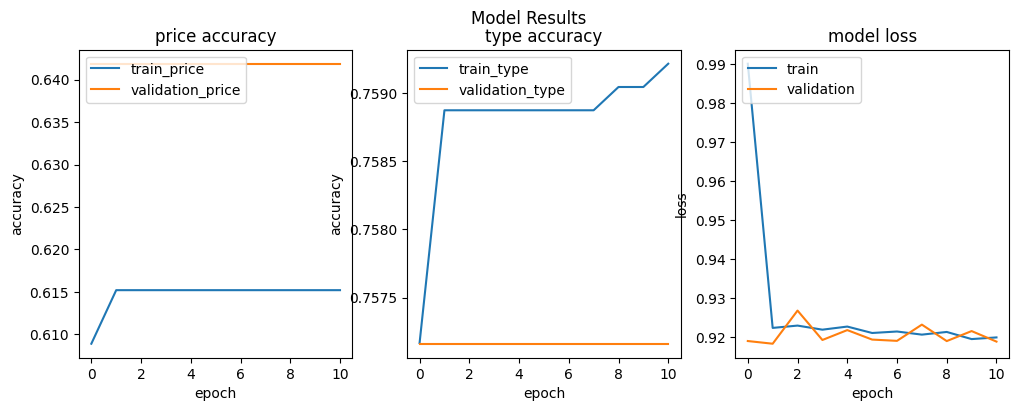

In [24]:
visualize(history)

Observation: surprisingly the model actually had a poorer performance than the last trial

# Trial 3
## GRU
The Gated Recurrent Unit (GRU) is a type of Recurrent Neural Network (RNN) that, in certain cases, has advantages over long short term memory (LSTM). GRU uses less memory and is faster than LSTM, however, LSTM is more accurate when using datasets with longer sequences.

In [25]:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2)) # input shape for batches of images (size 64x64x2)

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # get our word embeddings
# averaged = tf.reduce_mean(embedded, axis=1) # compute the mean of the embeddings to reduce the rank of the embedding
lstm = GRU(20)(embedded) # fewer hidden units might improve training time?

# image part
cov = Conv2D(32, (16, 16))(in_image) # convolutional layer with 32 filters, and a 16x16 mask, no padding
pl = MaxPool2D((16, 16))(cov) # max pooling with a 16x16 mask, reducing the size to 3x3x32
flattened = Flatten()(pl) # flatten the shape


# fusion:
fused = tf.concat([lstm, flattened], axis=-1) # concatenate text features with images

# multi-objectives (each is a multi-class classification)
p_price = Dense(len_price, activation='softmax', name='price')(fused) # predict price label 0, 1, or 2
p_type = Dense(len_type, activation='softmax', name='type')(fused) # predict rental category label [0-23]

# model definition
gru_model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price, # label 1: price category (0, 1, or 2)
        'type': p_type, # label 2: type category [0-23]
    },
)

# compile this new model including the GRU layer and print the architecture
compile(gru_model)
gru_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 49, 49, 32)   16416       ['input_6[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 100)     4000000     ['input_5[0][0]']                
                                                                                            

In [26]:
#train the model
history = train(gru_model, callbacks)

Epoch 1/20
367/367 [==============================] - 28s 65ms/step - loss: 1.0248 - price_loss: 0.8562 - type_loss: 1.1935 - price_sparse_categorical_accuracy: 0.6152 - type_sparse_categorical_accuracy: 0.7532 - val_loss: 0.9196 - val_price_loss: 0.8271 - val_type_loss: 1.0120 - val_price_sparse_categorical_accuracy: 0.6419 - val_type_sparse_categorical_accuracy: 0.7572
Epoch 2/20
367/367 [==============================] - 7s 20ms/step - loss: 0.9215 - price_loss: 0.8414 - type_loss: 1.0016 - price_sparse_categorical_accuracy: 0.6152 - type_sparse_categorical_accuracy: 0.7589 - val_loss: 0.9269 - val_price_loss: 0.8415 - val_type_loss: 1.0124 - val_price_sparse_categorical_accuracy: 0.6419 - val_type_sparse_categorical_accuracy: 0.7572
Epoch 3/20
367/367 [==============================] - 7s 19ms/step - loss: 0.9217 - price_loss: 0.8420 - type_loss: 1.0013 - price_sparse_categorical_accuracy: 0.6152 - type_sparse_categorical_accuracy: 0.7589 - val_loss: 0.9185 - val_price_loss: 0.8253

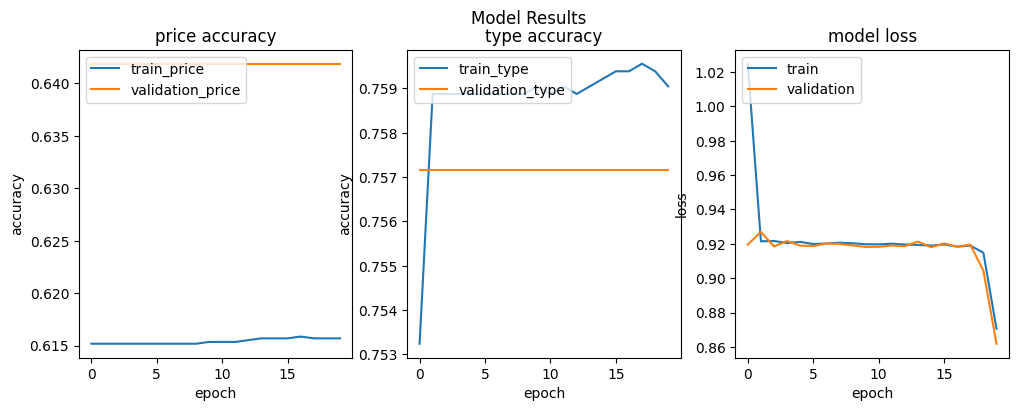

In [27]:
visualize(history)

In [28]:
#start predicting the values of type and price using summary and image as inputs
first_prediction = model.predict(
    {
        'summary': x_test_text,
        'image': x_test_image
    }
)


# probabilities
first_prediction = first_prediction['price']
print(first_prediction)

# categories
first_prediction = np.argmax(first_prediction, axis=1)
print(first_prediction)

230/230 [==============================] - 1s 4ms/step
[[0.56458646 0.36991054 0.06550295]
 [0.9442115  0.05065702 0.00513152]
 [0.76687866 0.18687929 0.04624208]
 ...
 [0.71599346 0.25830284 0.02570374]
 [0.9567259  0.03624928 0.00702484]
 [0.77077734 0.20296623 0.02625648]]
[0 0 0 ... 0 0 0]


In [29]:
pd.DataFrame(
    {'id': df_test['id'],
     'price': first_prediction}
).to_csv('trial3.csv', index=False)

#Trial 4
## Text part
- Embedding layer
- averaged layer
## Image part
- Convolutional layer
- Max pooling 
- Dropout = 0.30% 
- Flatten layer

In [31]:
# Two inputs, one for image and the other for text.
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text)# embedding requires to encoded input data to integer encoded, so that each word is represented by a unique integer
averaged = tf.reduce_mean(embedded, axis=1)  # reduce_mean that compute the mean value of embeddded


# image part 
# Conv2D is a two-dimensional convolution layer that generates a tensor of outputs by winding a convolution kernel with the layers input
# MaxPool2D used to reduces the dimensionality of images that is  by reducing the number of pixels in the output from the previous convolutional layer.
cov = Conv2D(32, (16, 16))(in_image)  # convolutional layer with 32 filters, and a 16*16 mask, no padding
pl = MaxPool2D((16, 16))(cov)  # max pooling with a 16*16 mask
pl=Dropout(0.3)(pl) # 30% dropout
flattened = Flatten()(pl) # flatten the shape to (288,)

# fusion - combinig both the text and the image
fused = tf.concat([averaged, flattened], axis=-1)

# multi-task learning (each is a multi-class classification)
# one dense layer for each task(type and price)
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)


# define model input/output using keys.
model = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)
compile(model)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 49, 49, 32)   16416       ['input_10[0][0]']               
                                                                                                  
 input_9 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 3, 3, 32)    0           ['conv2d_4[0][0]']               
                                                                                            

In [32]:
history = train(model, callbacks)

Epoch 1/20
367/367 [==============================] - 25s 61ms/step - loss: 1.0444 - price_loss: 0.8578 - type_loss: 1.2310 - price_sparse_categorical_accuracy: 0.6133 - type_sparse_categorical_accuracy: 0.7551 - val_loss: 0.9083 - val_price_loss: 0.8172 - val_type_loss: 0.9994 - val_price_sparse_categorical_accuracy: 0.6419 - val_type_sparse_categorical_accuracy: 0.7572
Epoch 2/20
367/367 [==============================] - 6s 17ms/step - loss: 0.8962 - price_loss: 0.8138 - type_loss: 0.9786 - price_sparse_categorical_accuracy: 0.6205 - type_sparse_categorical_accuracy: 0.7589 - val_loss: 0.8781 - val_price_loss: 0.7803 - val_type_loss: 0.9759 - val_price_sparse_categorical_accuracy: 0.6501 - val_type_sparse_categorical_accuracy: 0.7572
Epoch 3/20
367/367 [==============================] - 6s 15ms/step - loss: 0.8538 - price_loss: 0.7645 - type_loss: 0.9431 - price_sparse_categorical_accuracy: 0.6524 - type_sparse_categorical_accuracy: 0.7589 - val_loss: 0.8428 - val_price_loss: 0.7421

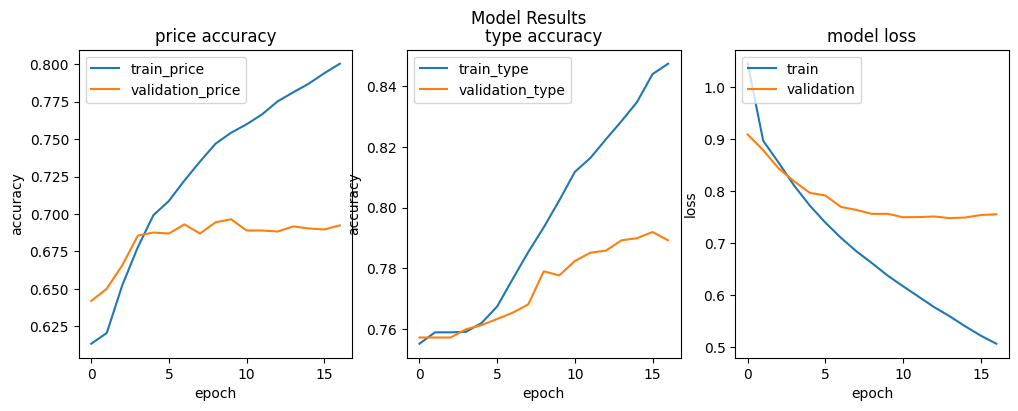

In [33]:
visualize(history)

looks like the model is vulnerable to overfitting but it has better scores than the last 2 trials

In [34]:
#start predicting the values of type and price using summary and image as inputs
first_prediction = model.predict(
    {
        'summary': x_test_text,
        'image': x_test_image
    }
)


# probabilities
first_prediction = first_prediction['price']
print(first_prediction)

# categories
first_prediction = np.argmax(first_prediction, axis=1)
print(first_prediction)

pd.DataFrame(
    {'id': df_test['id'],
     'price': first_prediction}
).to_csv('trial4.csv', index=False)


230/230 [==============================] - 1s 3ms/step
[[0.5726945  0.34870058 0.07860492]
 [0.97450703 0.02184352 0.00364953]
 [0.80720156 0.14401366 0.04878482]
 ...
 [0.77701944 0.20148472 0.02149576]
 [0.98584056 0.01009754 0.00406194]
 [0.84737873 0.131181   0.02144025]]
[0 0 0 ... 0 0 0]


Observation: 67.282 on kaggle less by 0.2% than the first trial

#Trial 5
we can try using dropout on the trial 1 to improve on it

In [35]:
in_text = keras.Input(batch_shape=(None, max_len)) # input shape for batches of text sequences (100 words long)
in_image = keras.Input(batch_shape=(None, 64, 64, 2)) # input shape for batches of images (size 64x64x2)

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # get our word embeddings
dropout= Dropout(.3)(embedded)
averaged = tf.reduce_mean(embedded, axis=1) # compute the mean of the embeddings to reduce the rank of the embedding


# image part
cov = Conv2D(32, (16, 16))(in_image) # convolutional layer with 32 filters, and a 16x16 mask, no padding
dropout= Dropout(.3)(cov)
pl = MaxPool2D((16, 16))(dropout) # max pooling with a 16x16 mask, reducing the size to 3x3x32
flattened = Flatten()(pl) # flatten the shape to (288,)


# fusion:
fused = tf.concat([averaged, flattened], axis=-1) # concatenate text features with images

# multi-objectives (each is a multi-class classification)
p_price = Dense(len_price, activation='softmax', name='price')(fused) # predict price label 0, 1, or 2
p_type = Dense(len_type, activation='softmax', name='type')(fused) # predict rental category label [0-23]

# model definition
model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price, # label 1: price category (0, 1, or 2)
        'type': p_type, # label 2: type category [0-23]
    },
)

# compile model
model.compile(
    optimizer=Adam(), # using Adam for optimization
    # measuring sparse categorical cross-entropy loss for both price and type labels
    # sparse categorical cross-entropy is used since our labels are integers
    loss={
        'price': 'sparse_categorical_crossentropy',
        'type': 'sparse_categorical_crossentropy',
    },
    # equally weight the loss w.r.t. both labels
    loss_weights={
        'price': 0.5,
        'type': 0.5,       
    },
    # evaluation metric for this task is accuracy, so we measure sparse categorical accuracy for both targets
    # again, our labels are categorical integers, so we use sparse categorical accuracy
    metrics={
        'price': ['SparseCategoricalAccuracy'],
        'type': ['SparseCategoricalAccuracy'],
    },
)


model.summary() # print the structure of the model defined above 

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 49, 49, 32)   16416       ['input_12[0][0]']               
                                                                                                  
 input_11 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 dropout_4 (Dropout)            (None, 49, 49, 32)   0           ['conv2d_5[0][0]']               
                                                                                            

In [36]:
# increasing the batch size to 64 to improve training speed, still 20 epochs
history = train(model, callbacks, 20, 64) # using a batch size of 64 to speed up training

Epoch 1/20
92/92 [==============================] - 25s 246ms/step - loss: 1.4711 - price_loss: 0.9201 - type_loss: 2.0220 - price_sparse_categorical_accuracy: 0.5997 - type_sparse_categorical_accuracy: 0.7381 - val_loss: 0.9860 - val_price_loss: 0.8334 - val_type_loss: 1.1385 - val_price_sparse_categorical_accuracy: 0.6419 - val_type_sparse_categorical_accuracy: 0.7572
Epoch 2/20
92/92 [==============================] - 10s 103ms/step - loss: 0.9208 - price_loss: 0.8342 - type_loss: 1.0075 - price_sparse_categorical_accuracy: 0.6152 - type_sparse_categorical_accuracy: 0.7589 - val_loss: 0.9465 - val_price_loss: 0.8231 - val_type_loss: 1.0698 - val_price_sparse_categorical_accuracy: 0.6419 - val_type_sparse_categorical_accuracy: 0.7572
Epoch 3/20
92/92 [==============================] - 7s 78ms/step - loss: 0.9070 - price_loss: 0.8245 - type_loss: 0.9895 - price_sparse_categorical_accuracy: 0.6152 - type_sparse_categorical_accuracy: 0.7589 - val_loss: 0.9302 - val_price_loss: 0.8121 - 

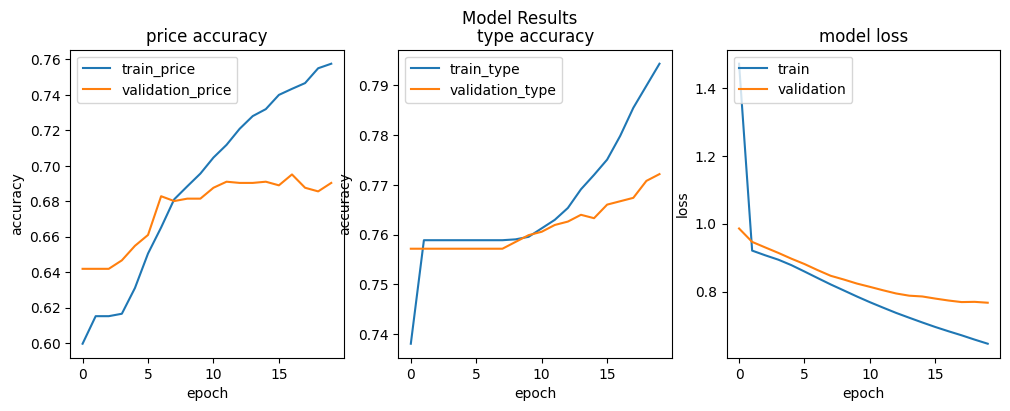

In [37]:
visualize(history)

In [38]:
#start predicting the values of type and price using summary and image as inputs
first_prediction = model.predict(
    {
        'summary': x_test_text,
        'image': x_test_image
    }
)


# probabilities
first_prediction = first_prediction['price']
print(first_prediction)

# categories
first_prediction = np.argmax(first_prediction, axis=1)
print(first_prediction)

pd.DataFrame(
    {'id': df_test['id'],
     'price': first_prediction}
).to_csv('trial5.csv', index=False)


230/230 [==============================] - 1s 2ms/step
[[0.58499986 0.33604893 0.0789512 ]
 [0.90281224 0.083035   0.01415276]
 [0.746418   0.19317791 0.06040416]
 ...
 [0.7077556  0.25357807 0.03866631]
 [0.92564297 0.05480413 0.01955283]
 [0.7008837  0.24961407 0.0495022 ]]
[0 0 0 ... 0 0 0]


#Trial 6
try using text only with no images

In [39]:
# Two inputs, one for image and the other for text.
in_text = keras.Input(batch_shape=(None, max_len))

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # embedding requires to encoded input data to integer encoded, so that each word is represented by a unique integer
averaged = tf.reduce_mean(embedded, axis=1)  # reduce_mean that compute the mean value of embeddded
averaged= Dropout(0.5)(averaged)# 50% dropout




# fusion - combinig both the text and the image
fused = averaged

# multi-task learning (each is a multi-class classification)
# one dense layer for each task(type and price)
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)


# define model input/output using keys.
model = keras.Model(
    inputs={
        'summary': in_text    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)


# compile model with optimizer, loss values for each task, loss 
# weights for each task.
compile(model)


model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 100, 100)     4000000     ['input_13[0][0]']               
                                                                                                  
 tf.math.reduce_mean_4 (TFOpLam  (None, 100)         0           ['embedding_6[0][0]']            
 bda)                                                                                             
                                                                                                  
 dropout_5 (Dropout)            (None, 100)          0           ['tf.math.reduce_mean_4[0][

In [40]:
history = train(model, callbacks)

Epoch 1/20


/usr/local/lib/python3.9/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['image'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


367/367 [==============================] - 34s 89ms/step - loss: 1.1773 - price_loss: 0.8802 - type_loss: 1.4744 - price_sparse_categorical_accuracy: 0.6031 - type_sparse_categorical_accuracy: 0.7473 - val_loss: 0.9098 - val_price_loss: 0.8181 - val_type_loss: 1.0014 - val_price_sparse_categorical_accuracy: 0.6419 - val_type_sparse_categorical_accuracy: 0.7572
Epoch 2/20
367/367 [==============================] - 9s 23ms/step - loss: 0.9115 - price_loss: 0.8306 - type_loss: 0.9925 - price_sparse_categorical_accuracy: 0.6159 - type_sparse_categorical_accuracy: 0.7589 - val_loss: 0.8920 - val_price_loss: 0.8033 - val_type_loss: 0.9808 - val_price_sparse_categorical_accuracy: 0.6419 - val_type_sparse_categorical_accuracy: 0.7572
Epoch 3/20
367/367 [==============================] - 5s 14ms/step - loss: 0.8957 - price_loss: 0.8155 - type_loss: 0.9758 - price_sparse_categorical_accuracy: 0.6184 - type_sparse_categorical_accuracy: 0.7589 - val_loss: 0.8789 - val_price_loss: 0.7935 - val_type

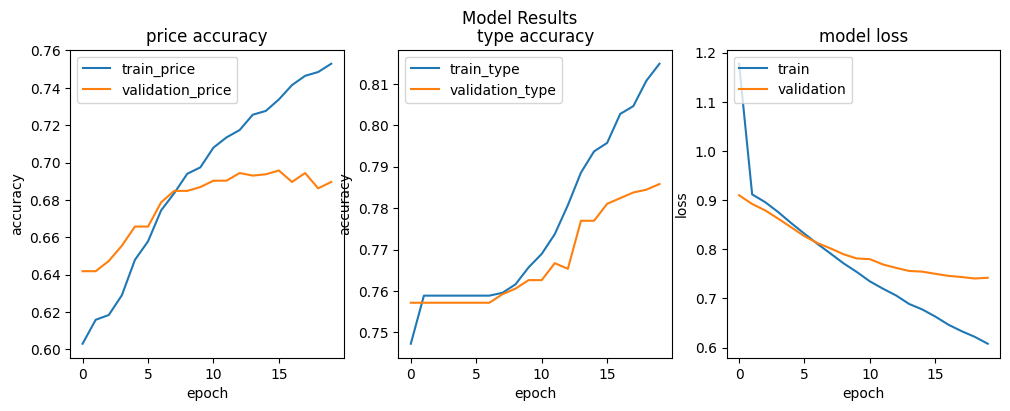

In [41]:
visualize(history)

In [42]:
#start predicting the values of type and price using summary and image as inputs
first_prediction = model.predict(
    {
        'summary': x_test_text,
        'image': x_test_image
    }
)


# probabilities
first_prediction = first_prediction['price']
print(first_prediction)

# categories
first_prediction = np.argmax(first_prediction, axis=1)
print(first_prediction)

pd.DataFrame(
    {'id': df_test['id'],
     'price': first_prediction}
).to_csv('trial6.csv', index=False)


 38/230 [===>..........................] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['image'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


230/230 [==============================] - 1s 3ms/step
[[0.6528858  0.2867761  0.06033806]
 [0.9507763  0.04320981 0.00601388]
 [0.81205666 0.14507645 0.04286682]
 ...
 [0.7922706  0.18409507 0.02363431]
 [0.9594676  0.0319555  0.0085769 ]
 [0.8015664  0.17241985 0.02601373]]
[0 0 0 ... 0 0 0]


#Bonus Trial
### i used VGG pretrained model

In [44]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Rescaling



In [45]:
# VGG needs input images with 3 channels, so I'll extend the training data to have 3 channels and appear RGB
# x_tr_image is currently (6101, 64, 64, 2)
rgb_tr = x_tr_image[:,:,:,0]
rgb_vl = x_vl_image[:,:,:,0]
# rgb.shape # now it's (6101, 64, 64)
rgb_tr = np.repeat(rgb_tr[..., np.newaxis], 3, -1) # repeat the same values across 3 channels
rgb_vl = np.repeat(rgb_vl[..., np.newaxis], 3, -1) # repeat the same values across 3 channel



# bringing VGG16 into the mix
base = VGG16(include_top=False, input_shape=(64,64,3)) # instantiating the base model we wish to tune
base.trainable = False # freezing the weights

58889256/58889256 [==============================] - 1s 0us/step


In [48]:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 3)) # input shape for batches of images (size 64x64x2)

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # get our word embeddings
# averaged = tf.reduce_mean(embedded, axis=1) # compute the mean of the embeddings to reduce the rank of the embedding
attention = MultiHeadAttention(num_heads=2, key_dim=2)(embedded, embedded)
bi_lstm = Bidirectional(GRU(50, recurrent_regularizer='l2'))(attention)


# image part
scaling = Rescaling(1./127.5, offset=-1)(in_image) # rescaling to [-1,1] for VGG16
vgg = base(scaling, training=False) # pass the base model the scaled inputs
pl = GlobalAveragePooling2D()(vgg) # global average pooling, pretty much the same as flattening
do = Dropout(0.2)(pl) # dropout at a rate of 20%
fl = Flatten()(do) # flattening anyways


# fusion:
fused = tf.concat([bi_lstm, fl], axis=-1) # concatenate text features with images

# multi-objectives (each is a multi-class classification)
p_price = Dense(len_price, activation='softmax', name='price')(fused) # predict price label 0, 1, or 2
p_type = Dense(len_type, activation='softmax', name='type')(fused) # predict rental category label [0-23]

# model definition
attn_model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price, # label 1: price category (0, 1, or 2)
        'type': p_type, # label 2: type category [0-23]
    },
)

# compiling the updated attention model and printing the summary
compile(attn_model)
attn_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 64, 64, 3)    0           ['input_18[0][0]']               
                                                                                                  
 input_17 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 vgg16 (Functional)             (None, 2, 2, 512)    14714688    ['rescaling[0][0]']              
                                                                                            

In [51]:
# history = train(lstm_model, callbacks)
history = attn_model.fit(
      # our inputs: tokenized text sequences and resized image samples
      x={
          'summary': x_tr_text,
          'image': rgb_tr # can't use my helper function as I have a different image input
      },
      # our outputs: price and rental type categories
      y={
          'price': y_tr_price,
          'type': y_tr_type,
      },
      epochs=20, # train for 20 epochs (iterations over all training data)
      batch_size=32, # batch size of 16 (samples processed before updating gradients)
      # our validation splits for our two input sets and our two target attributes
      validation_data=(
          {
              'summary': x_vl_text,
              'image': rgb_vl # can't use my helper function as I have a different validation set
          }, 
          {
              'price': y_vl_price,
              'type': y_vl_type,
          }),
      # validation_split=0.2, # validate on a hold-out set of 20%, even though splits were already created above???? This is redundant.
      # use early stopping, monitor the validation price loss and if it does not improve for 5 consecutive epochs, training will stop
      callbacks=[
          tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, ) # setting patience back to 5
      ],
      verbose=1 # one line per epoch displaying performance metrics
  )

Epoch 1/20
184/184 [==============================] - 39s 162ms/step - loss: 1.3244 - price_loss: 0.8625 - type_loss: 1.2248 - price_sparse_categorical_accuracy: 0.6041 - type_sparse_categorical_accuracy: 0.6976 - val_loss: 0.9427 - val_price_loss: 0.8255 - val_type_loss: 0.9958 - val_price_sparse_categorical_accuracy: 0.6419 - val_type_sparse_categorical_accuracy: 0.7572
Epoch 2/20
184/184 [==============================] - 14s 75ms/step - loss: 0.8876 - price_loss: 0.8249 - type_loss: 0.9299 - price_sparse_categorical_accuracy: 0.6160 - type_sparse_categorical_accuracy: 0.7599 - val_loss: 0.8481 - val_price_loss: 0.7858 - val_type_loss: 0.9058 - val_price_sparse_categorical_accuracy: 0.6385 - val_type_sparse_categorical_accuracy: 0.7592
Epoch 3/20
184/184 [==============================] - 12s 64ms/step - loss: 0.8237 - price_loss: 0.7938 - type_loss: 0.8505 - price_sparse_categorical_accuracy: 0.6234 - type_sparse_categorical_accuracy: 0.7662 - val_loss: 0.8301 - val_price_loss: 0.7

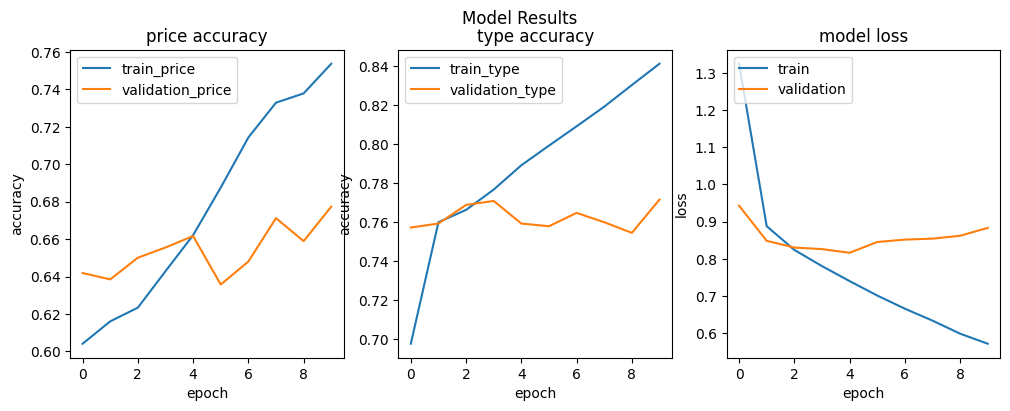

In [52]:
visualize(history)

In [53]:
# preprocess the test images the same way as our training and validation sets
rgb_test = x_test_image[:,:,:,0]
rgb_test = np.repeat(rgb_test[..., np.newaxis], 3, -1) # repeat the same values across 3 channels

In [54]:
y_predict = attn_model.predict(
    {
        'summary': x_test_text,
        'image': rgb_test
    }
)
price_predicted = y_predict['price'] 
price_category_predicted = np.argmax(price_predicted, axis=1) 

# create the submission dataframe/csv for submission
pd.DataFrame(
    {'id': df_test.id,
    'price': price_category_predicted}).to_csv('bonus_trial.csv', index=False)

230/230 [==============================] - 5s 16ms/step


Oservation: 67% on kaggle